# HWAI Project

Import section

In [17]:
import sys, os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
from keras.applications import MobileNetV2
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import visualkeras, logging

# my import
from modules import models

#suppress warnings
tf.get_logger().setLevel(logging.ERROR)

In [18]:
IMAGESIZE = 128 #TODO: Check arduino cam size
DATADIR = "/home/mattiamorabito/Documents/HwAi-linux/train/"
DATADIRT = "/home/mattiamorabito/Documents/HwAi-linux/test/"

Check if GPU is mounted

In [19]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


2023-04-24 12:04:21.887041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 12:04:21.887512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-24 12:04:21.887667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loading dataset

In [20]:
#train_ds = [1,2]
#Load training set
#train_ds[0] = tf.keras.utils.image_dataset_from_directory(DATADIR,labels='inferred',label_mode='categorical',shuffle=True,image_size=(IMAGESIZE, IMAGESIZE))
#Load validation set
#train_ds[1] = tf.keras.utils.image_dataset_from_directory(DATADIRV,labels='inferred',label_mode='categorical',shuffle=True,image_size=(IMAGESIZE, IMAGESIZE))

#normalization layer to rescale the images
normalization_layer = tf.keras.layers.Rescaling(1./255)

#small dataset to run tests
train_ds = tf.keras.utils.image_dataset_from_directory(DATADIR,seed = 26,labels='inferred',validation_split=.15,subset='both',label_mode='categorical',shuffle=True,image_size=(IMAGESIZE, IMAGESIZE))
classes = train_ds[1].class_names
#prefetch for performance and rescale
train_ds[0] = train_ds[0].map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)    # cache and prefetch of the first element (the training set)
train_ds[1] = train_ds[1].map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 8648 files belonging to 8 classes.
Using 7351 files for training.
Using 1297 files for validation.


Model instances and visualization

In [21]:
# Istanciate Model    
#model = models.deep_tiny_x5_xl()
model = models.minimalmodel(num_classes=8)
model.summary()
visualkeras.layered_view(model,legend=True).show() # display using your system viewer


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mnet (Functional)           (None, 4, 4, 576)         441000    
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 4616      
                                                                 
Total params: 445,616
Trainable params: 433,504
Non-trainable params: 12,112
_________________________________________________________________


Model training

In [14]:
#set checkpoint
checkpoint = ModelCheckpoint('savedmodels/minimalV3_transfer_2404.h5', save_best_only=True)
#train with gpu
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds[0],
        epochs=10,
        batch_size=32,
        callbacks=[
            checkpoint,
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.8, min_lr=1e-6)
            ],
        validation_data=train_ds[1]
    )

Epoch 1/5


2023-04-24 11:54:25.248218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [7441]
	 [[{{node Placeholder/_4}}]]
2023-04-24 11:54:25.248974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [7441]
	 [[{{node Placeholder/_0}}]]


233/233 [==============================] - ETA: 0s - loss: 2.2513 - accuracy: 0.2119

2023-04-24 11:54:36.707847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1312]
	 [[{{node Placeholder/_4}}]]
2023-04-24 11:54:36.708071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1312]
	 [[{{node Placeholder/_4}}]]


233/233 [==============================] - 13s 44ms/step - loss: 2.2513 - accuracy: 0.2119 - val_loss: 1.8194 - val_accuracy: 0.3483 - lr: 2.0000e-05
Epoch 2/5
233/233 [==============================] - 8s 34ms/step - loss: 1.4521 - accuracy: 0.4979 - val_loss: 1.1826 - val_accuracy: 0.5770 - lr: 2.0000e-05
Epoch 3/5
233/233 [==============================] - 8s 34ms/step - loss: 1.0208 - accuracy: 0.6690 - val_loss: 0.8285 - val_accuracy: 0.7188 - lr: 2.0000e-05
Epoch 4/5
233/233 [==============================] - 8s 34ms/step - loss: 0.7575 - accuracy: 0.7539 - val_loss: 0.6131 - val_accuracy: 0.8011 - lr: 2.0000e-05
Epoch 5/5
233/233 [==============================] - 8s 34ms/step - loss: 0.6075 - accuracy: 0.8093 - val_loss: 0.4776 - val_accuracy: 0.8544 - lr: 2.0000e-05


TFLITE

Evaluate performance

Evaluate
Found 270 files belonging to 8 classes.


  0%|          | 0/14 [00:00<?, ?it/s]2023-04-24 11:55:13.200097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [270]
	 [[{{node Placeholder/_0}}]]
2023-04-24 11:55:13.200491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [270]
	 [[{{node Placeholder/_0}}]]
100%|██████████| 14/14 [00:01<00:00,  9.33it/s]


0.6259259259259259


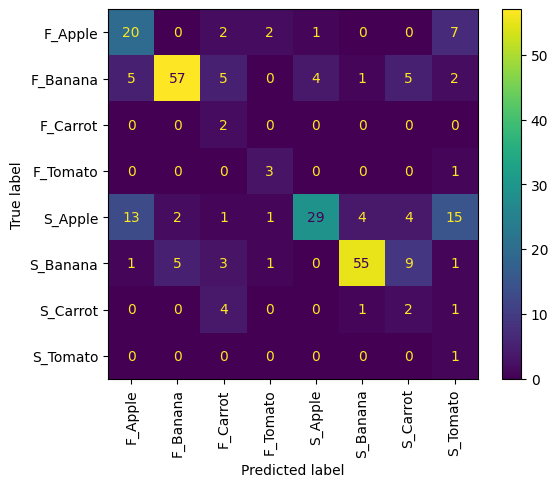

In [15]:
print("Evaluate")
#load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(DATADIRT,labels='inferred',batch_size=20,label_mode='categorical',image_size=(IMAGESIZE, IMAGESIZE))
#extract class names
classes = test_dataset.class_names



#rescale
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
#test_dataset = train_ds[1]
#TODO: move to utils
#get predictions
predictions = np.array([])
labels =  np.array([])
for x, y in tqdm(test_dataset):
  # selecet the class for which i have the max confidence
  predictions = np.concatenate([predictions, np.argmax(model.predict(x,verbose=0), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

print(accuracy_score(labels, predictions))
t = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=t,display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.show()


See model structure and history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0

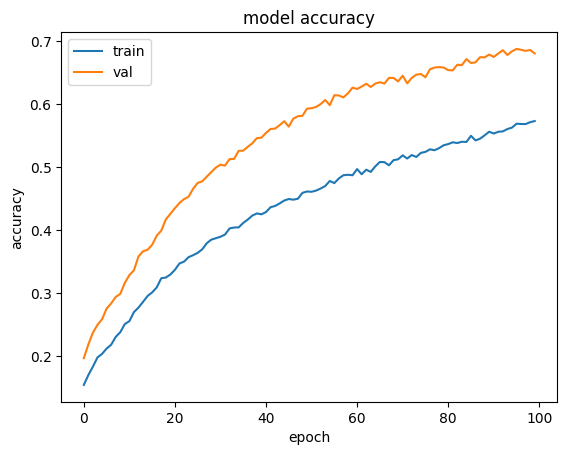

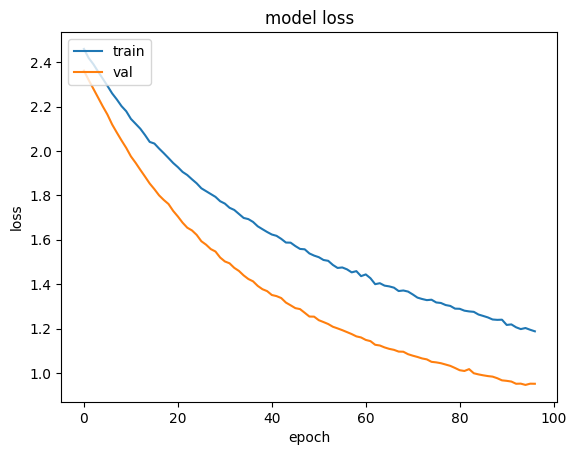

In [26]:

# see model structure
visualkeras.layered_view(model,legend=True).show() # display using your system viewer
model.summary()

# model training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Weight distrubution

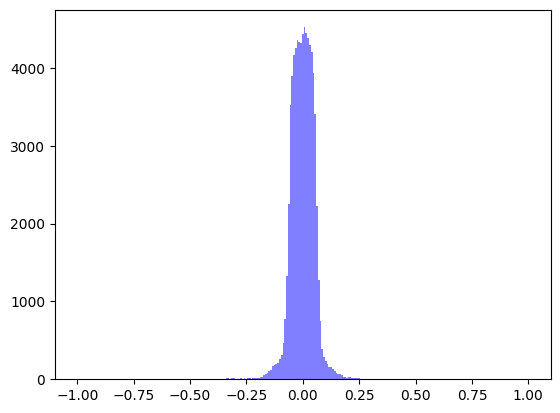

In [30]:
all_wi = []
wi = model.weights
for elem in wi:
  var = list(elem.read_value().numpy().flatten())
  all_wi= all_wi +var
s = np.array(all_wi)
sbins = np.linspace(-1,1,256)
plt.hist(s, bins=sbins, facecolor='blue', alpha=0.5)
plt.show()